<a href="https://colab.research.google.com/github/sivatanujgunta/AItriesTrading/blob/main/AItriesMinutely.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
%%capture install_log
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2';
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1;
!pip install conda-package-handling;
!wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda;
!cph x ta-lib-0.5.1-py311h9ecbd09_0.conda;
!mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/;

In [113]:
import yfinance as yf
import pandas as pd
import talib as ta
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [65]:
# Fetch historical data for a stock
symbol = 'AAPL'  # Stock symbol to trade
start_date = (datetime.datetime.now() - datetime.timedelta(days=2)).strftime('%Y-%m-%d')
end_date = datetime.datetime.now().strftime('%Y-%m-%d')

In [66]:
# Fetch minutely data (1-minute intervals for a given stock symbol)
data = yf.download(symbol, start=start_date, end=end_date, interval='1m')
close_prices = data['Close'].to_numpy().ravel()

[*********************100%***********************]  1 of 1 completed


In [67]:
# Calculate Moving Average Convergence Divergence (MACD) and Signal Line
data['MACD'], data['MACD_Signal'], data['MACD_Hist'] = ta.MACD(close_prices, fastperiod=12, slowperiod=26, signalperiod=9)

In [68]:
# Calculate Short-Term and Long-Term SMAs
data['SMA_Short'] = ta.SMA(close_prices, timeperiod=50)  # 50-period SMA (Short-term)
data['SMA_Long'] = ta.SMA(close_prices, timeperiod=200)  # 200-period SMA (Long-term)

In [89]:
# Generate Buy and Sell signals
data['Signal'] = 0  # 1 for Buy, -1 for Sell, 0 for Hold

# Strategy 1 - MACD and SMA crossover
data.loc[(data['MACD'] > data['MACD_Signal']) & (data['SMA_Short'] > data['SMA_Long']), 'Signal'] = 1
data.loc[(data['MACD'] < data['MACD_Signal']) & (data['SMA_Short'] < data['SMA_Long']), 'Signal'] = -1

# Strategy 2 - MACD crossover
data.loc[(data['MACD'] > data['MACD_Signal']), 'Signal'] = 1
data.loc[(data['MACD'] < data['MACD_Signal']), 'Signal'] = -1

In [90]:
# Trading parameters
initial_balance = 10000  # Starting balance

In [116]:
# Simulate trading
balance = initial_balance
position = 0  # No position initially
buy_price = 0
trade_log = []
portfolio_value_history = []  # To track the portfolio value over time
for index, row in data.iterrows():
    close = row['Close'].item()
    if row['Signal'].item() == 1 and position == 0:  # Buy
        position = balance / close
        buy_price = close
        # print(f"Buy at {row['Close']} on {row.name}")
        trade_log.append(f"Buy {position} shares at {buy_price} on {row.name.strftime('%Y-%m-%d %H:%M:%S')}")
    elif row['Signal'].item() == -1 and position > 0:  # Sell
        balance = position * close
        pl = position * (close - buy_price)
        # print(f"Sell at {row['Close']} on {row.name}")
        if pl >= 0:
            trade_log.append(f"Sell {position} shares at {close} on {row.name.strftime('%Y-%m-%d %H:%M:%S')} (Profit: {pl}")
        else:
            trade_log.append(f"Sell {position} shares at {close} on {row.name.strftime('%Y-%m-%d %H:%M:%S')} (Loss: {pl}")
        position = 0

    # Track portfolio value after each trade
    portfolio_value_history.append(balance + position * close)

# If there's a position left at the end of the period, sell
if position > 0:
    balance = position * data.iloc[-1]['Close'].item()
    # print(f"Sell at {data.iloc[-1]['Close']} on {data.index[-1]}")
    trade_log.append(f"Sell {position} shares at {data.iloc[-1]['Close'].item()} on {data.index[-1].strftime('%Y-%m-%d %H:%M:%S')}")
    position = 0
    portfolio_value_history.append(balance)

In [117]:
# Output results
final_balance = balance
print(f"Final Balance: {final_balance}")
print(f"Total profit/loss: {final_balance - initial_balance}")

Final Balance: 9987.474597611934
Total profit/loss: -12.52540238806614


In [118]:
# Print trade log
for trade in trade_log:
    print(trade)

total_trades = len([trade for trade in trade_log if "Profit" in trade or "Loss" in trade])
winning_trades = len([trade for trade in trade_log if "Profit" in trade])
losing_trades = len([trade for trade in trade_log if "Loss" in trade])

print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades}")
print(f"Losing Trades: {losing_trades}")

Buy 50.67198602932768 shares at 197.3477020263672 on 2025-04-04 14:19:00
Sell 50.67198602932768 shares at 196.22000122070312 on 2025-04-04 14:23:00 (Loss: -57.14283946987094
Buy 51.64718173676371 shares at 192.51499938964844 on 2025-04-04 14:54:00
Sell 51.64718173676371 shares at 195.72999572753906 on 2025-04-04 15:19:00 (Profit: 166.0455001460669
Buy 51.854939271143685 shares at 194.94580078125 on 2025-04-04 15:46:00
Sell 51.854939271143685 shares at 194.52999877929688 on 2025-04-04 15:58:00 (Loss: -21.561387560099266
Buy 51.74067625275861 shares at 194.9595947265625 on 2025-04-04 16:13:00
Sell 51.74067625275861 shares at 194.66000366210938 on 2025-04-04 16:14:00 (Loss: -15.501044274088478
Buy 52.29679848568775 shares at 192.58999633789062 on 2025-04-04 16:32:00
Sell 52.29679848568775 shares at 192.88999938964844 on 2025-04-04 16:50:00 (Profit: 15.689199142869674
Buy 52.177775474290165 shares at 193.3300018310547 on 2025-04-04 16:51:00
Sell 52.177775474290165 shares at 192.875 on 2025

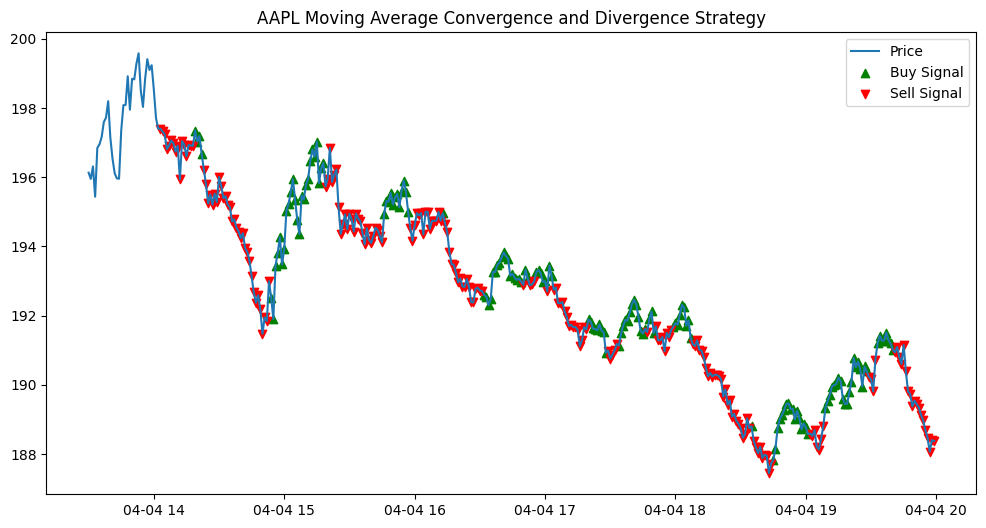

In [119]:
# Plot the price with buy and sell signals
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Price')
plt.scatter(data.index[data['Signal'] == 1], data['Close'][data['Signal'] == 1], marker='^', color='g', label='Buy Signal')
plt.scatter(data.index[data['Signal'] == -1], data['Close'][data['Signal'] == -1], marker='v', color='r', label='Sell Signal')
plt.title(f'{symbol} Moving Average Convergence and Divergence Strategy')
plt.legend()
plt.show()

In [120]:
# Calculate additional performance metrics

if total_trades > 0:
    win_rate = winning_trades / total_trades

    # Calculate Max drawdown
    max_value = portfolio_value_history[0]  # Initial value is the first portfolio value
    max_drawdown = 0  # Placeholder for max drawdown calculation
    for value in portfolio_value_history:
        drawdown = (max_value - value) / max_value  # Calculate drawdown as percentage
        max_drawdown = max(max_drawdown, drawdown)  # Update max drawdown if necessary
        max_value = max(max_value, value)  # Update the peak value (highest portfolio value)

    average_win = np.mean([float(trade.split("(")[1].split(":")[1].split(")")[0]) for trade in trade_log if "Profit" in trade]) if winning_trades else 0
    average_loss = np.mean([abs(float(trade.split("(")[1].split(":")[1].split(")")[0])) for trade in trade_log if "Loss" in trade]) if losing_trades else 0
    profit_factor = (sum(float(trade.split("(")[1].split(":")[1].split(")")[0]) for trade in trade_log if "Profit" in trade) /
                     abs(sum(float(trade.split("(")[1].split(":")[1].split(")")[0]) for trade in trade_log if "Loss" in trade))) if losing_trades else 0

    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2f}")  # Placeholder, needs calculation
    print(f"Average Win: {average_win:.2f}")
    print(f"Average Loss: {average_loss:.2f}")
    print(f"Profit Factor: {profit_factor:.2f}")
else:
    print("No trades executed.")

Total Trades: 16
Win Rate: 0.31
Max Drawdown: 0.51
Average Win: 58.00
Average Loss: 27.50
Profit Factor: 0.96
